#### Before you run the notebook, make sure the homework files provided are in the same directory.
```
150180705/  
    hw4.ipynb  
    biped_1.avi
    biped_2.avi
    biped_3.avi
```

## PART 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from scipy.signal import convolve2d
import cv2

import os

import pdb

In [2]:
def get_video_frames(fname):
    video = mpy.VideoFileClip(fname)
    n_frames = video.reader.nframes
    fps = video.fps
    
    frames = []
    for i in range(n_frames):
        frame = video.get_frame(i*1.0/fps)
        frames.append(frame)
        
    return frames, n_frames, fps

In [41]:
def lucas_kanade(image1, image2, points, window_size=5, blur_window_size=None, tau=1e-2, grayscale=False):
    assert type(points) == list, "Param 'points' must be type list"
    assert type(grayscale) == bool, "Param 'grayscale' must be type bool"
    
    if grayscale:
        gray_im1 = image1
        gray_im2 = image2
    else:
        gray_im1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        gray_im2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    if blur_window_size:
        assert type(blur_window_size) == int, "Param 'blur_window_size' must be type int"
        gray_im1 = cv2.GaussianBlur(gray_im1, (blur_window_size, blur_window_size), 0)
        gray_im2 = cv2.GaussianBlur(gray_im2, (blur_window_size, blur_window_size), 0)

    of_directions = []
    points_next = []
    for point in points:
        x_coord, y_coord = point
        w = window_size // 2

        x_filter = np.array([[-1, 1], [-1, 1]], np.float64) * 1/4
        y_filter = np.array([[-1, -1], [1, 1]], np.float64) * 1/4
        t_filter = np.array([[1, 1], [1, 1]], np.float64) * 1/4

        Ix = convolve2d(gray_im1, x_filter, "same") + convolve2d(gray_im2, x_filter, "same")    # Derivative in X direction
        Iy = convolve2d(gray_im1, y_filter, "same") + convolve2d(gray_im2, y_filter, "same")    # Derivative in Y direction
        It = convolve2d(gray_im1, t_filter, "same") + convolve2d(gray_im2, -t_filter, "same")    # Derivative in XY direction

        # Method applied below is explained here in details
        # http://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/tutorials/Lucas-Kanade2.pdf
        Sx = Ix[y_coord-w:y_coord+w+1, x_coord-w:x_coord+w+1].flatten()
        Sy = Iy[y_coord-w:y_coord+w+1, x_coord-w:x_coord+w+1].flatten()
        St = It[y_coord-w:y_coord+w+1, x_coord-w:x_coord+w+1].flatten()

        S = np.array([[np.sum(np.power(Sx, 2)), np.sum(np.multiply(Sx, Sy))],
                      [np.sum(np.multiply(Sx, Sy)), np.sum(np.power(Sy, 2))]])
        U = np.array([[np.sum(np.multiply(Sx, St))],
                      [np.sum(np.multiply(Sy, St))]])

        # Instead of calculating the eigenvalues matrix by hand, I used pinv for a similar result
        # pinv handles the ill condition for us <3
        of_direction = np.dot(np.linalg.pinv(S), -U)
        
        of_directions.append(np.array([of_direction[0], of_direction[1]]))
        x_next_coord = int(x_coord + np.round(of_direction[0]))
        y_next_coord = int(y_coord + np.round(of_direction[1]))
        points_next.append((x_next_coord, y_next_coord))
    
    of_directions = np.array(of_directions)
    return points_next, of_directions

In [23]:
def draw_arrow(frame, points, of_directions, scale_factor=5, thickness=1, tip_length=0.3):
    of_directions = of_directions.reshape((-1, 2))
    points_next = np.round(np.add(points, np.multiply(of_directions, scale_factor)))
    
    start_pos = tuple(np.mean(points, axis=0, dtype=np.int32))
    end_pos = tuple(np.mean(points_next, axis=0, dtype=np.int32))

    color = (255, 190, 25)    # Yellow (RGB)
    frame = cv2.arrowedLine(frame, start_pos, end_pos, color, thickness, tipLength=tip_length)
    return frame

In [24]:
def render_video(frames, fname, fps=30):
    clip = mpy.ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(fname, codec='libx264')

Driver code below

In [42]:
video_fname = "biped_1.avi"
frames, n_frames, fps = get_video_frames(video_fname)

points = [(396, 334), (405, 335)]    # Left bot and right bot corners of hand

i = 0
while i < n_frames - 1:
    f = frames[i]
    f_next = frames[i+1]
    points_next, of_directions = lucas_kanade(f, f_next, points, window_size=3, blur_window_size=3)
    
    frames[i] = draw_arrow(f, points, of_directions, scale_factor=10, thickness=2, tip_length=0.2)
    points = points_next
    i += 1
    
render_video(frames, "biped_1_tracked.mp4", fps)

t:  31%|███       | 48/154 [00:00<00:00, 431.89it/s, now=None]

Moviepy - Building video biped_1_tracked.mp4.
Moviepy - Writing video biped_1_tracked.mp4



Moviepy - Done !
Moviepy - video ready biped_1_tracked.mp4


## PART 2

In [73]:
def background_subtraction(frame, sub_corners, grayscale=False):
    assert type(grayscale) == bool, "Param 'grayscale' must be type bool"
    
    if grayscale:
        gray_frame = frame
    else:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    x1, y1 = sub_corners[0]
    x2, y2 = sub_corners[1]
    
    # Turn whites into blacks
    full_mask = np.zeros(gray_frame.shape, dtype=np.bool)
    full_mask[y1:y2, x1:x2] = gray_frame[y1:y2, x1:x2] > 235
    gray_frame[full_mask] = 10
    return gray_frame

In [122]:
video_fname = "biped_2.avi"
frames, n_frames, fps = get_video_frames(video_fname)

sub_corners = [(360, 280), (450, 380)]    # Top left, bottom right corners of the subtractable region

sub_frames = [background_subtraction(frame, sub_corners) for frame in frames]

corner_p1 = [(212, 185)]    # Top left
corner_p2 = [(305, 184)]    # Top right
corner_p3 = [(211, 314)]    # Bottom left
corner_p4 = [(305, 314)]    # Bottom right

hand_p = [(396, 334), (405, 335)]    # Left bot and right bot corners of hand

i = 0
while i < n_frames - 2:
    f = sub_frames[i]
    f_next = sub_frames[i+1]
    f_next2 = sub_frames[i+2]
    
    # Use two frames ahead in time
    corner_p1_next, cp1_of = lucas_kanade(f, f_next2, corner_p1, window_size=25, blur_window_size=3, grayscale=True)
    frames[i] = draw_arrow(frames[i], corner_p1, cp1_of, scale_factor=15, thickness=2, tip_length=0.2)
    corner_p2_next, cp2_of = lucas_kanade(f, f_next2, corner_p2, window_size=25, blur_window_size=3, grayscale=True)
    frames[i] = draw_arrow(frames[i], corner_p2, cp2_of, scale_factor=15, thickness=2, tip_length=0.2)
    corner_p3_next, cp3_of = lucas_kanade(f, f_next2, corner_p3, window_size=25, blur_window_size=3, grayscale=True)
    frames[i] = draw_arrow(frames[i], corner_p3, cp3_of, scale_factor=15, thickness=2, tip_length=0.2)
    corner_p4_next, cp4_of = lucas_kanade(f, f_next2, corner_p4, window_size=25, blur_window_size=3, grayscale=True)
    frames[i] = draw_arrow(frames[i], corner_p4, cp4_of, scale_factor=15, thickness=2, tip_length=0.2)
    # Use one frame ahead in time
    hand_p_next, hand_of = lucas_kanade(f, f_next, hand_p, window_size=7, blur_window_size=3, grayscale=True)
    frames[i] = draw_arrow(frames[i], hand_p, hand_of, scale_factor=10, thickness=2, tip_length=0.2)
    hand_p = hand_p_next
    i += 1
    
render_video(frames, "biped_2_tracked.avi", fps)

t:  31%|███       | 48/154 [00:00<00:00, 354.86it/s, now=None]

Moviepy - Building video biped_2_tracked.avi.
Moviepy - Writing video biped_2_tracked.avi



Moviepy - Done !
Moviepy - video ready biped_2_tracked.avi


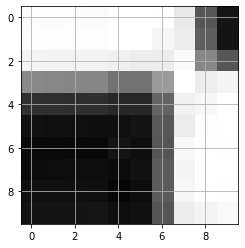

In [109]:
# frame1 = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
plt.imshow(frames[0][180:190, 300:310, :])
# plt.imshow(sub_frames[0])
# plt.imshow(sub_frames[0][240:400, 320:480])
# print(sub_frames[0][340, 380])
# plt.imshow(frames[0])
# plt.imshow(frame1)
plt.grid(True)
# plt.axis(False)
# plt.savefig("vid2_frame1.png")

## PART 3